In [6]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from PIL import Image
from networkx.drawing.nx_pydot import graphviz_layout

# %matplotlib widget

#### Dataset
    Data of animals being cat or dog, features are ear shape, face shape, whiskers
    
    We will use one-hot encoding to encode the categorical features. They will be as follows:

            Ear Shape: Pointy = 1, Floppy = 0
            Face Shape: Round = 1, Not Round = 0
            Whiskers: Present = 1, Absent = 0
    
    Therefore, we have two sets:

    X_train: for each example, contains 3 features: - Ear Shape (1 if pointy, 0 otherwise) - Face Shape (1 if round, 0 otherwise) - Whiskers (1 if present, 0 otherwise)

    y_train: whether the animal is a cat - 1 if the animal is a cat - 0 otherwise

In [7]:
#data of animals being cat or dog, features are ear shape, face shape, whiskers
X_train = np.array([[1, 1, 1],
[0, 0, 1],
 [0, 1, 0],
 [1, 0, 1],
 [1, 1, 1],
 [1, 1, 0],
 [0, 0, 0],
 [1, 1, 0],
 [0, 1, 0],
 [0, 1, 0]])

y_train = np.array([1, 1, 0, 0, 1, 1, 0, 1, 0, 0])

In [8]:
def compute_entropy(p):
    entropy = 0.0
    if p not in [0, 1]:
        entropy = - (p * np.log2(p)) - ((1 - p) * np.log2(1 - p))
    return entropy

def compute_information_gain(node_indices, left_indices, right_indices, y):
    information_gain = 0.0
#     node_c1 = np.where(y[node_indices]==1)[0] #accesing index of empty list when class=1 is empty, gives index axes out of range
#     left_c1 = np.where(y[left_indices]==1)[0]
#     right_c1 = np.where(y[right_indices]==1)[0]
    node_c1 = sum(y[node_indices]) #just add the examples of class which is just equal to len(y[indices]==1)
    left_c1 = sum(y[left_indices])
    right_c1 = sum(y[right_indices])
    p_node = node_c1 / len(node_indices)
    p_left = left_c1 / len(left_indices)
    p_right = right_c1 / len(right_indices)
    H_node = compute_entropy(p_node)
    H_left = compute_entropy(p_left)
    H_right = compute_entropy(p_right)
    w_left = len(left_indices) / len(node_indices)
    w_right = len(right_indices) / len(node_indices)
    information_gain = H_node - ((w_left * H_left) + (w_right * H_right))
    return information_gain
    
def split_data(X, node_indices, feature_idx):
    left_indices = []
    right_indices = []
    for i  in node_indices:
        if X[i, feature_idx] == 1:
            left_indices.append(i)
        else:
            right_indices.append(i)
    return left_indices, right_indices

def get_best_split(X, y, node_indices):
    best_feature_idx = -1
    max_info_gain = 0.0
    left_indices_ = []
    right_indices_ = []
    for feature_idx in range(X.shape[1]):
        left_indices, right_indices = split_data(X, node_indices, feature_idx)
        if len(left_indices) > 0 and len(right_indices) > 0: #to avoid zero by division error   
            info_gain = compute_information_gain(node_indices, left_indices, right_indices, y)
            if info_gain > max_info_gain:
                max_info_gain = info_gain
                left_indices_ = left_indices
                right_indices_ = right_indices
                best_feature_idx = feature_idx
    return best_feature_idx, left_indices_, right_indices_, max_info_gain

def build_decision_tree(X, y, node_indices, node_name, feature_names, max_depth, current_depth, tree, threshold):
    best_split_feature_idx, left_indices, right_indices, max_info_gain = get_best_split(X, y, node_indices)
    
    #stopping criteria
    if current_depth == max_depth or len(set(y[node_indices]))==1 or max_info_gain < threshold:
        formatting = " " * current_depth + "-" * current_depth
        print(f"{formatting} {node_name} Leaf Node, indices: {node_indices}")
        return
    
    tree.append((left_indices, right_indices, best_split_feature_idx))
    formatting = "-" * current_depth
    print(f"{formatting} Depth {current_depth}, {node_name} Node, Split Feature on {best_split_feature_idx} {feature_names[best_split_feature_idx]}")
    
    build_decision_tree(X, y, left_indices, "Left", feature_names, max_depth, current_depth+1, tree, threshold) #we expand the left subtree until it reaches max depth
    build_decision_tree(X, y, right_indices, "Right", feature_names, max_depth, current_depth+1, tree, threshold) #and then right subtree expansion

In [9]:
tree = [] #to be filles with indices at each node
root_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] #all the training example at root index
feature_names = ["Earshape", "Faceshape", "Whiskers"]
build_decision_tree(X_train, y_train, root_indices, "Root", feature_names, max_depth=2, current_depth=0, tree=tree, threshold=0.1)

 Depth 0, Root Node, Split Feature on 0 Earshape
- Depth 1, Left Node, Split Feature on 1 Faceshape
  -- Left Leaf Node, indices: [0, 4, 5, 7]
  -- Right Leaf Node, indices: [3]
- Depth 1, Right Node, Split Feature on 2 Whiskers
  -- Left Leaf Node, indices: [1]
  -- Right Leaf Node, indices: [2, 6, 8, 9]


In [10]:
print(tree)

[([0, 3, 4, 5, 7], [1, 2, 6, 8, 9], 0), ([0, 4, 5, 7], [3], 1), ([1], [2, 6, 8, 9], 2)]


In [11]:
image_paths = [f"./decision_tree_images/assignment_images/{i}.png" for i in root_indices]
images = [Image.open(img) for img in image_paths]
widths, heights = list(zip(*[img.size for img in images]))
total_widths = sum(widths)
max_height = max(heights)
new_image_width = total_widths / len(widths)
new_image_height = max_height / len(heights)
print(new_image_width)
print(new_image_height)

89.8
8.0


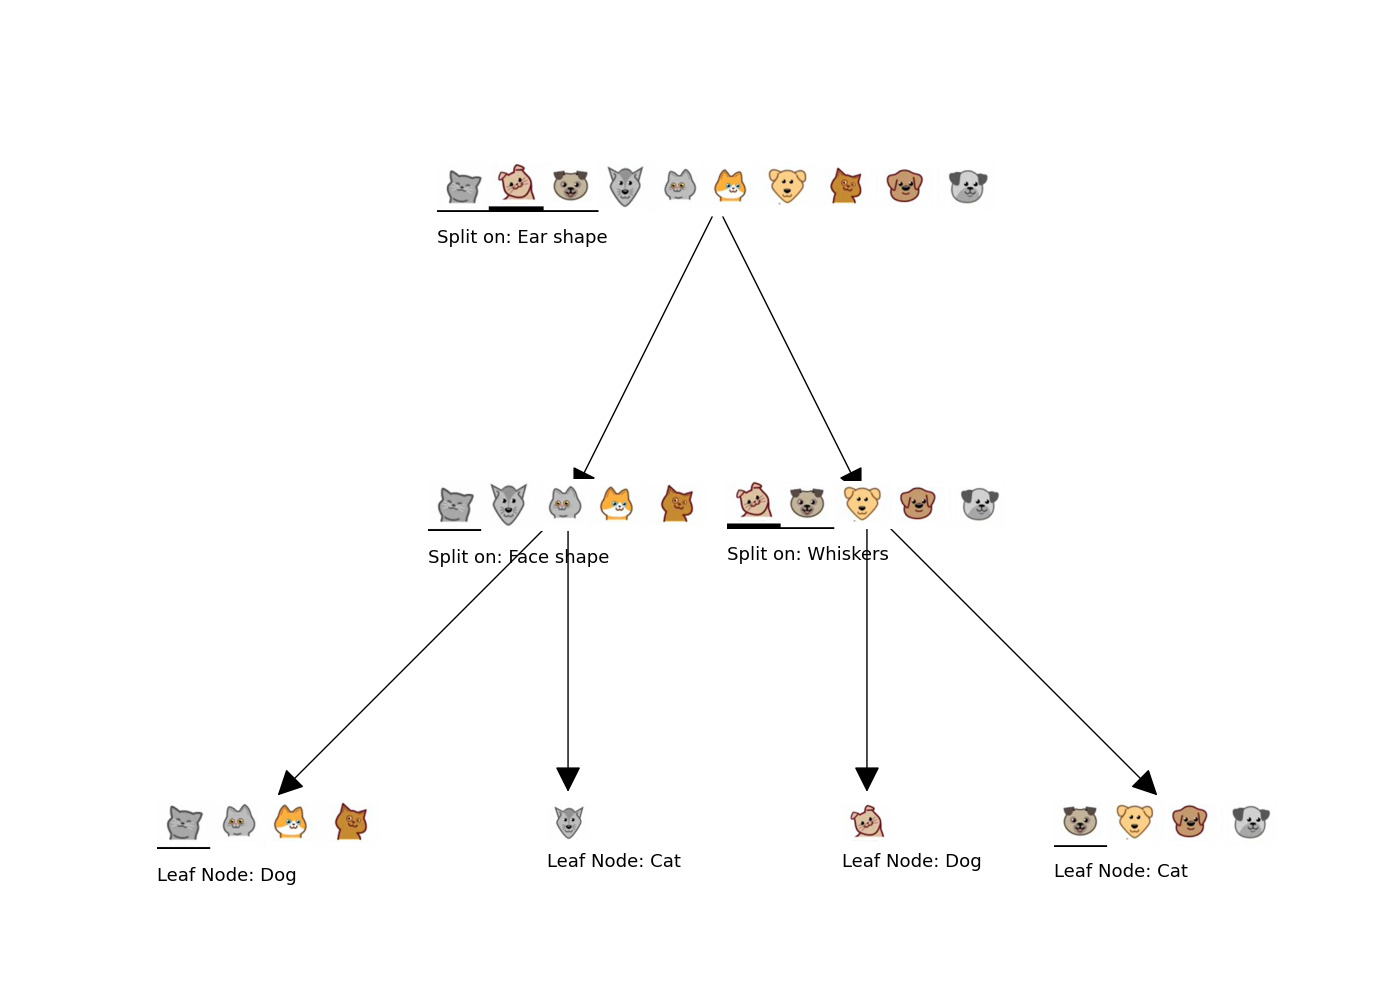

In [12]:
import networkx
from networkx.drawing.nx_pydot import graphviz_layout
from PIL import Image
import matplotlib.pyplot as plt

def generate_node_images(node_indices):
    image_paths = [f"./decision_tree_images/assignment_images/{i}.png" for i in node_indices]
    images = [Image.open(img) for img in image_paths]
    widths, heights = zip(*(img.size for img in images))
    total_widths = sum(widths)
    max_height = max(heights)
    
    new_image_width = int(total_widths * len(node_indices) / 10)
    new_image_height = int(max_height * len(node_indices) / 10)
    new_img = Image.new("RGB", (total_widths, max_height))
    
    x_offset = 0
    for img in images:
        new_img.paste(img, (x_offset, 0))
        x_offset += img.size[0]
    new_img.resize((new_image_width, new_image_height))
        
    return new_img

def visualize_tree(root_indices, tree, y):
    G = nx.DiGraph()
    idx = 1
    root = 0
    G.add_node(str(root), image=generate_node_images(root_indices)) #rootnode
    #for title at each node
    decision_node_names = []
    leaf_node_classes_names = []
    num_images = [len(root_indices)]
    feature_names = ["Ear shape", "Face shape", "Whiskers"]
    y_labels = ["Cat","Dog"]
    
    #decision nodes
    for i, level in enumerate(tree):
        for indices in level[:2]:
            G.add_node(str(idx), image=generate_node_images(indices))
            G.add_edge(str(root), str(idx))
            idx += 1
            num_images.append(len(indices))
            if i > 0:
                leaf_node_classes_names.append(f"Leaf Node: {y_labels[max(y[indices])]}")
        decision_node_names.append(f"Split on: {feature_names[level[2]]}")
        root += 1
          
    
    node_names = decision_node_names + leaf_node_classes_names
    pos = graphviz_layout(G, prog="dot")
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111)
    ax.set_aspect("equal")
    nx.draw_networkx_edges(G, pos=pos, ax=ax, arrows=True, arrowsize=40)
    
    trans = ax.transData.transform
    trans2 = fig.transFigure.inverted().transform
    
    for i, node in enumerate(G):
        xx, yy = trans(pos[node]) #get the display coordinates
        xa, ya = trans2((xx, yy)) #get the figure coordinates from display coordinates
        piesize = num_images[i] / 25
        p = piesize / 2.0
        a = plt.axes([xa-p, ya-p, piesize, piesize])
        a.imshow(G.nodes[node]["image"])
        a.axis("off")
        a.set_aspect("equal")
        a.set_title(node_names[i], y=-0.8, fontsize=13, loc="left")
    ax.axis("off")  
    plt.show()
    
    
plt.close("all")
visualize_tree(root_indices, tree, y_train)

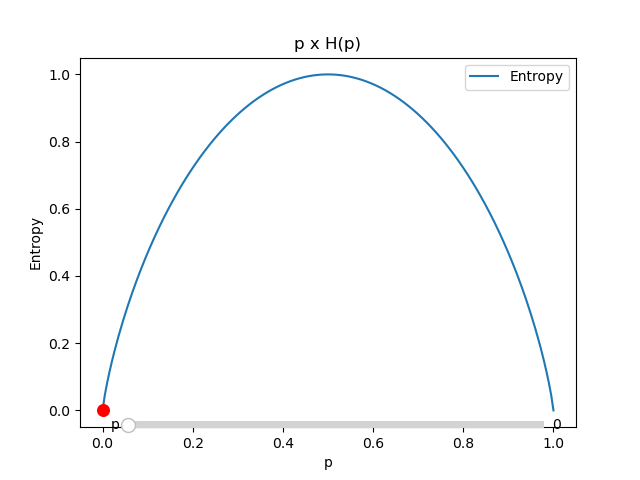

In [13]:
from matplotlib.widgets import Slider
%matplotlib widget
def plot_entropy(compute_entropy):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    p_array = np.linspace(0, 1, 200)
    entropy = [compute_entropy(p) for p in p_array]
    ax.plot(p_array, entropy, label="Entropy")
    scatter = ax.scatter(x=0, y=0, c="r", zorder=100, s=70)
    slider_axes = plt.axes([0.2, 0.1, 0.65, 0.03])
    ax.legend()
    s1 = Slider(slider_axes, label="p", valmin=0.0, valinit=0.0, valmax=1.0, valstep=0.05)
    def update(val):
        p = s1.val
        entropy = compute_entropy(p)
        scatter.set_offsets((p, entropy))
        
    s1.on_changed(update)
    ax.set_xlabel("p"); ax.set_ylabel("Entropy")
    ax.set_title("p x H(p)")
    plt.show()
    
plot_entropy(compute_entropy)